# G211 gridpoints inside CONUS shapes
<li> G211 module pickle mask
    <li> Natural Earth low res
<li> share/shapeFiles/CONUS

In [2]:
import logging
import os
import pickle

import cartopy.crs as ccrs
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray
from shapely.geometry import Polygon

import G211
from statisticplot import make_map

<div>
    <img src="https://www.nco.ncep.noaa.gov/pmb/docs/on388/grids/grid211.gif", width="50%"/>
</div>

In [3]:
grid = G211
grid.grid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Naturalearth lowres USA - overlay lat/lon box around CONUS

/glade/derecho/scratch/ahijevyc/tmp/ipykernel_21495/266314292.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  poly = geopandas.GeoDataFrame.from_file(geopandas.datasets.get_path("naturalearth_lowres"))


<Axes: >

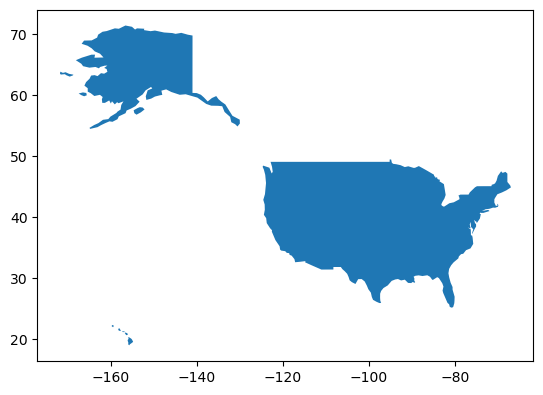

In [4]:
poly = geopandas.GeoDataFrame.from_file(geopandas.datasets.get_path("naturalearth_lowres"))
usa = poly[poly.iso_a3 == "USA"]
usa.plot()

<Axes: >

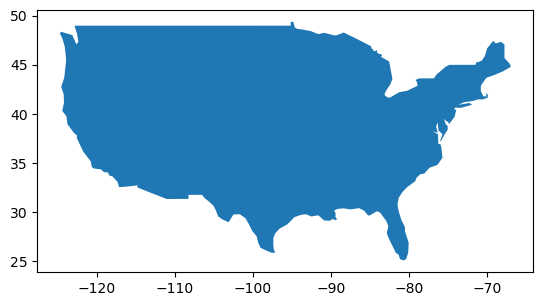

In [5]:
# lat/lon box around CONUS (no AK or HI)
lat_point_list = [51, 51, 20, 20, 51]
lon_point_list = [-130, -60, -60, -130, -130]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = geopandas.GeoDataFrame(crs=usa.crs, geometry=[polygon_geom])
conus = usa.overlay(polygon, how="intersection")
conus.plot()

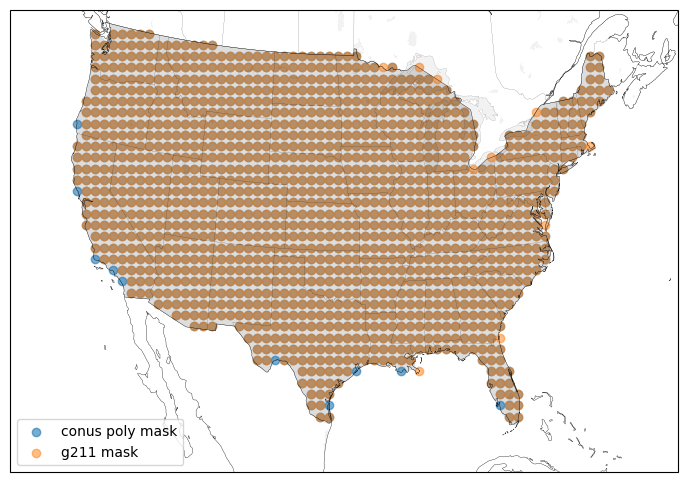

In [6]:
pointInPolys = grid.grid.to_crs(conus.crs).sjoin(conus)

fig, ax = make_map(bbox=[-125, -67, 20, 48])
conus.geometry.plot(ax=ax, color="#DDDDDD", transform=ccrs.PlateCarree())
pointInPolys.plot(ax=ax, alpha=0.6, transform=ccrs.PlateCarree(), label="conus poly mask")

g211_obj = grid.grid[grid.mask.values.flatten()].plot(
    ax=ax, alpha=0.5, transform=ccrs.PlateCarree(), label="g211 mask"
)
leg = plt.legend()

In [7]:
import folium

pointInPolys = grid.grid.to_crs(conus.crs).sjoin(conus)
m = pointInPolys.explore(marker_kwds=dict(radius=4), name="conus poly mask")
grid.grid[grid.mask.values.flatten()].explore(
    m=m, marker_kwds=dict(color="orange"), name="g211 mask"
)
folium.LayerControl().add_to(m)
m

# share/shapeFiles/CONUS minus HI, AK, territories

<Axes: >

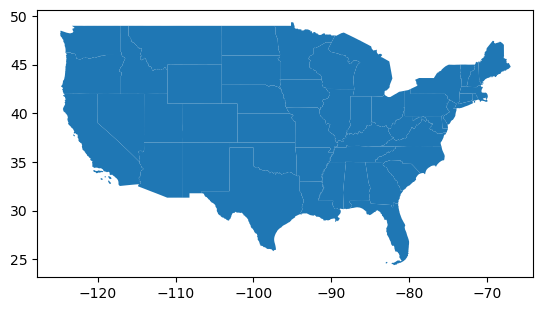

In [8]:
poly = geopandas.GeoDataFrame.from_file("/glade/work/ahijevyc/share/shapeFiles/CONUS")
# all STUSPS except these
conus = poly[~poly.STUSPS.isin(["HI", "PR", "VI", "AK", "GU", "MP", "AS"])]
conus.plot()

In [9]:
pointInPolys = grid.grid.sjoin(conus.to_crs(grid.grid.crs))
pointInPolys.head()

geometry  index_right REGION DIVISION STATEFP  \
y  x                                                                     
12 48  POINT (-98.22852 26.29913)           25      3        7      48   
   49  POINT (-97.41353 26.31442)           25      3        7      48   
   69  POINT (-81.15503 25.69390)            1      3        5      12   
   70  POINT (-80.34865 25.61680)            1      3        5      12   
13 47  POINT (-99.06764 27.01075)           25      3        7      48   

        STATENS GEOID STUSPS     NAME LSAD  MTFCC FUNCSTAT         ALAND  \
y  x                                                                       
12 48  01779801    48     TX    Texas   00  G4000        A  676641930188   
   49  01779801    48     TX    Texas   00  G4000        A  676641930188   
   69  00294478    12     FL  Florida   00  G4000        A  138911437206   
   70  00294478    12     FL  Florida   00  G4000        A  138911437206   
13 47  01779801    48     TX    Texas   00  G4000        A  676641930188   

            AWATER     INTPTLAT      INTPTLON  
y  x                                           
12 48  19017521093  +31.4347032  -099.2818238  
   49  19017521093  +31.4347032  -099.2818238  
   69  31398800291  +28.4574302  -082.4091478  
   70  31398800291  +28.4574302  -082.4091478  
13 47  19017521093  +31.4347032  -099.2818238

In [10]:
m = pointInPolys.explore(marker_kwds=dict(radius=4), name="conus poly mask")
grid.grid[grid.mask.values.flatten()].explore(
    m=m, marker_kwds=dict(color="orange"), name="g211 mask"
)
folium.LayerControl().add_to(m)
m

In [11]:
# dx times dy = area
a = np.diff(grid.xv, append=np.nan) * np.diff(grid.yv, axis=0, append=np.nan)
a /= 1000**2
a

array([[6603.15591562, 6603.15591562, 6603.15591562, ..., 6603.15591562,
        6603.15591562,           nan],
       [6603.15591562, 6603.15591562, 6603.15591562, ..., 6603.15591562,
        6603.15591562,           nan],
       [6603.15591562, 6603.15591562, 6603.15591562, ..., 6603.15591562,
        6603.15591562,           nan],
       ...,
       [6603.15591562, 6603.15591562, 6603.15591562, ..., 6603.15591562,
        6603.15591562,           nan],
       [6603.15591562, 6603.15591562, 6603.15591562, ..., 6603.15591562,
        6603.15591562,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])

In [12]:
np.nanmin(a), np.nanmax(a)

(6603.155915622299, 6603.155915622489)

In [13]:
np.diff(grid.xv).min(), np.diff(grid.xv).max()

(81421.36042639473, 81421.36042639613)

In [14]:
np.diff(grid.yv, axis=0).min(), np.diff(grid.yv, axis=0).max()

(81098.57021600101, 81098.57021600194)

In [15]:
# Load lat/lon from netCDF
ifile = "/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052200/post/mem_1/interp_mpas_3km_2024052200_mem1_f001.nc"
ds = xarray.open_dataset(ifile)
df = ds["refl10cm_max"].to_dataframe().reset_index()

In [16]:
mgrid = geopandas.GeoDataFrame(
    df.refl10cm_max,
    geometry=geopandas.points_from_xy(
        ds.longitude.values.ravel(), ds.latitude.values.ravel(), crs="EPSG:4326"
    ),
)
mgrid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
grid.grid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
gdf = mgrid.sjoin(conus.to_crs(mgrid.crs))
len(gdf)

905466

<Axes: >

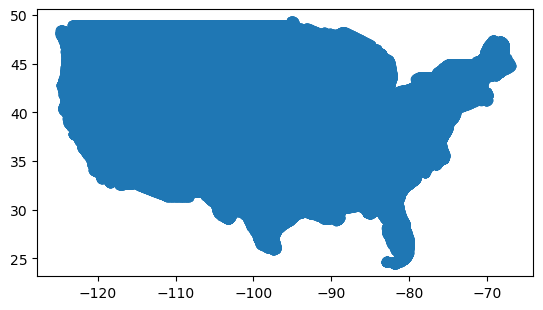

In [19]:
gdf.plot()

<Axes: >

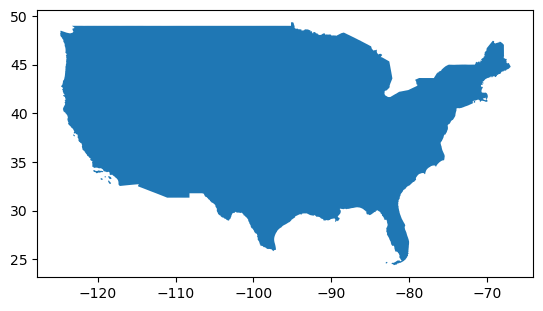

In [20]:
conus.dissolve().plot()  # .to_crs(mgrid.crs).contains(mgrid)

In [21]:
mgrid.head()

,refl10cm_max,geometry
0,-35.0,POINT (-122.71953 21.13812)
1,-35.0,POINT (-122.69286 21.14511)
2,-35.0,POINT (-122.66619 21.15209)
3,-35.0,POINT (-122.63952 21.15906)
4,-35.0,POINT (-122.61284 21.16603)


In [ ]:
from tqdm import tqdm

conus1 = conus.dissolve()
conus_mask = np.array([g.within(conus1.geometry.values[0]) for g in tqdm(mgrid.geometry)])
conus_mask.sum()

  1%|▏         | 26022/1905141 [03:42<7:50:19, 66.59it/s] 

In [ ]:
nlat, nlon = ds.lat.size, ds.lon.size
conus_mask = xarray.DataArray(
    conus_mask.reshape(nlat, nlon),
    dims=["lat", "lon"],
    coords={"lat": range(nlat), "lon": range(nlon)},
)
conus_mask.plot()

In [34]:
t = conus_mask.__xarray_dataarray_variable__
t.name = None
conus_mask.to_netcdf("HWT_2024.conus.nc")